<a href="https://colab.research.google.com/github/wangyouzhong/MLStudy/blob/master/Power_Prediction_MultiTask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [1]:
import io
import pandas as pd

from google.colab import files

import numpy as np
from datetime import date, timedelta

In [2]:
# add daily sum and time bucket ratio to daily sum as features
NUM_TIME_BUCKETS = 96
START_INDEX_FEATURES = NUM_TIME_BUCKETS

def data_preprocess(df):
  df.columns = ['Id', 'Date'] + [f'TB{i}' for i in range(1, NUM_TIME_BUCKETS+1)]
  df['Date'] = pd.to_datetime(df['Date'])

  # Add daily sum features and time bucket ratio to daily sum
  global START_INDEX_FEATURES
  START_INDEX_FEATURES = NUM_TIME_BUCKETS * 2 + 1
  df['Day_Sum'] = df.apply(lambda row: np.sum(row[2:]), axis=1)
  for i in range(1, NUM_TIME_BUCKETS+1):
    df[f'TB{i}_Ratio'] = df.apply(lambda row: row[f'TB{i}'] / row['Day_Sum'], axis=1)
  return df

def data_shift_days(df, days_delta):
  df['Date'] = df['Date'] + pd.Timedelta(days=days_delta)
  return df

In [3]:
uploaded1 = files.upload()

Saving 131151000000000965.csv to 131151000000000965 (7).csv


In [4]:
df_l1 = pd.read_csv(io.BytesIO(uploaded1['131151000000000965.csv']), header=None)
df_l1 = data_preprocess(df_l1)
df_l1

,Id,Date,TB1,TB2,TB3,TB4,TB5,TB6,TB7,TB8,TB9,TB10,TB11,TB12,TB13,TB14,TB15,TB16,TB17,TB18,TB19,TB20,TB21,TB22,TB23,TB24,TB25,TB26,TB27,TB28,TB29,TB30,TB31,TB32,TB33,TB34,TB35,TB36,TB37,TB38,...,TB57_Ratio,TB58_Ratio,TB59_Ratio,TB60_Ratio,TB61_Ratio,TB62_Ratio,TB63_Ratio,TB64_Ratio,TB65_Ratio,TB66_Ratio,TB67_Ratio,TB68_Ratio,TB69_Ratio,TB70_Ratio,TB71_Ratio,TB72_Ratio,TB73_Ratio,TB74_Ratio,TB75_Ratio,TB76_Ratio,TB77_Ratio,TB78_Ratio,TB79_Ratio,TB80_Ratio,TB81_Ratio,TB82_Ratio,TB83_Ratio,TB84_Ratio,TB85_Ratio,TB86_Ratio,TB87_Ratio,TB88_Ratio,TB89_Ratio,TB90_Ratio,TB91_Ratio,TB92_Ratio,TB93_Ratio,TB94_Ratio,TB95_Ratio,TB96_Ratio
0,131151000000000965,2019-01-01,6443.213757,6339.668505,6061.736719,5927.823626,5639.515694,5508.766597,5316.491736,5380.208712,5031.950200,5025.861779,4997.452673,5103.937301,4783.836779,4832.434695,4656.268152,4739.768857,4670.468852,4689.179001,4836.636411,4621.116499,4676.205351,4746.822644,4674.089757,4748.315526,4770.425894,5060.843908,5198.606405,5452.185223,5630.595512,5649.892755,6083.688899,6407.585852,6937.257085,7556.494095,7962.109581,8535.704714,9391.133595,10203.874188,...,0.013734,0.013738,0.013910,0.013858,0.013806,0.013907,0.014100,0.014101,0.013890,0.013997,0.013796,0.013349,0.013738,0.013757,0.014048,0.013880,0.014131,0.014293,0.014259,0.014782,0.014474,0.014136,0.014734,0.014504,0.014543,0.014667,0.015059,0.014350,0.014001,0.014201,0.013762,0.012837,0.011108,0.010243,0.009444,0.008673,0.008391,0.008126,0.007645,0.007307
1,131151000000000965,2019-01-02,6420.070735,6159.470428,5902.046334,5912.334804,5612.788344,5443.938055,5232.428793,5269.273807,5005.868278,4972.147160,4921.269620,5060.840850,4749.933665,4685.472549,4599.818089,4643.062326,4584.296414,4625.539859,4790.562452,4621.935890,4568.799129,4663.123521,4592.185466,4680.662789,4714.732561,4958.732659,5141.139805,5397.173852,5524.925636,5570.967859,5985.648492,6378.632212,6901.530365,7460.776053,7836.412287,8392.216686,9238.686600,10061.429916,...,0.013830,0.013719,0.013927,0.014032,0.014011,0.013841,0.014018,0.014095,0.013945,0.013951,0.013728,0.013382,0.013656,0.013651,0.014056,0.013981,0.014383,0.014311,0.014266,0.014499,0.014569,0.014041,0.014564,0.014574,0.014590,0.014577,0.015015,0.014453,0.014120,0.014214,0.013730,0.012976,0.011126,0.010289,0.009543,0.008661,0.008455,0.008179,0.007681,0.007365
2,131151000000000965,2019-01-03,6020.718906,5928.042346,5677.283981,5601.382808,5377.565376,5175.709286,4957.847887,5079.748909,4763.842930,4793.673425,4681.720531,4811.449393,4571.442143,4464.729430,4420.783510,4465.832158,4365.294295,4440.332626,4548.564671,4358.165908,4424.041235,4466.324146,4361.214556,4460.774421,4482.159051,4691.892720,4899.219378,5086.718509,5220.855066,5359.628493,5761.974275,6043.349767,6566.527046,6986.406602,7403.576768,8038.583335,8786.628991,9601.203647,...,0.013794,0.013645,0.013841,0.013981,0.013921,0.013966,0.014028,0.013898,0.013822,0.014034,0.013904,0.013412,0.013754,0.013661,0.013830,0.013987,0.014301,0.014287,0.014228,0.014546,0.014456,0.014155,0.014610,0.014503,0.014556,0.014738,0.015122,0.014481,0.014110,0.013967,0.013610,0.012867,0.011151,0.010284,0.009509,0.008758,0.008413,0.008173,0.007712,0.007334
3,131151000000000965,2019-01-04,6342.713285,6156.494852,5925.388196,5865.362370,5590.985021,5381.203993,5191.810029,5298.470919,4988.903983,4974.633462,4975.443436,5093.157973,4691.661945,4703.524029,4586.497132,4583.323665,4568.442918,4590.523509,4772.311086,4539.198872,4571.561594,4663.919072,4558.323979,4675.140663,4711.150449,4924.799387,5028.210001,5317.970369,5481.806522,5554.154846,6000.158311,6357.582975,6849.557466,7339.592980,7775.399651,8271.971729,9186.893023,9966.620744,...,0.013785,0.013645,0.013851,0.014006,0.014003,0.013717,0.013907,0.013898,0.013868,0.014007,0.013727,0.013522,0.013742,0.013730,0.013974,0.013886,0.014340,0.014468,0.014443,0.014678,0.014586,0.014195,0.014810,0.014581,0.014654,0.014553,0.015056,0.014275,0.013990,0.014031,0.013735,0.012886,0.011026,0.010289,0.009488,0

In [5]:
uploaded3 = files.upload()

Saving L3.csv to L3 (3).csv


In [6]:
df_l3 = pd.read_csv(io.BytesIO(uploaded3['L3.csv']))
df_l3 = data_preprocess(df_l3)

In [7]:
def build_train_data(df1, df3, start_ds, end_ds, shift_days):
  train_data = pd.DataFrame.copy(df3[(df3['Date']>=start_ds) & (df3['Date']<=end_ds)]).set_index('Date')
  
  # Join L3 data with L1 previous days data
  for i in range(1, shift_days+1):
    df_shift = pd.DataFrame.copy(df1[(df1['Date']>=(start_ds + timedelta(days=-i))) & (df1['Date']<=(end_ds + timedelta(days=-i)))])
    df_shift = data_shift_days(df_shift, i).drop(columns=['Id']).set_index('Date')
    train_data = train_data.join(df_shift, rsuffix=f'_d{i}_L1')
  
  # Join L3 data with L3 previous days data
  train_data = train_data.reset_index().set_index(['Date', 'Id'])
  for i in range(1, shift_days+1):
    df_shift = pd.DataFrame.copy(df3[(df3['Date']>=(start_ds + timedelta(days=-i))) & (df3['Date']<=(end_ds + timedelta(days=-i)))])
    df_shift = data_shift_days(df_shift, i).set_index(['Date', 'Id'])
    train_data = train_data.join(df_shift, rsuffix=f'_d{i}')
  
  # Add id and week of days as one hot features
  train_data = train_data.reset_index()
  train_data = pd.concat(
      [
       train_data, 
       pd.get_dummies(train_data['Id'], prefix='Id'),
       pd.get_dummies(train_data.apply(lambda row: row['Date'].weekday(), axis=1), prefix='Weekday')
       ],axis=1).set_index(['Date', 'Id'])

  return train_data

In [8]:
TRAIN_DS_START = pd.to_datetime('2019-01-08')
TRAIN_DS_END = pd.to_datetime('2019-03-15')
VALIDATE_DS_START = pd.to_datetime('2019-03-16')
VALIDATE_DS_END = pd.to_datetime('2019-03-23')

NUM_PREVIOUS_DAYS = 7

In [9]:
train_data = build_train_data(df_l1, df_l3, TRAIN_DS_START, TRAIN_DS_END, NUM_PREVIOUS_DAYS)
train_data

TB1  ...  Weekday_6
Date                Id                               ...           
2019-01-08 00:00:00 139251010000000953   121.203910  ...          0
                    139251010000001761   168.781621  ...          0
                    139251010000002373    26.603336  ...          0
                    139251010000002711     3.666426  ...          0
                    139251010000002901     1.082868  ...          0
...                                             ...  ...        ...
2019-03-14 07:00:00 139251010000063005   145.808202  ...          0
                    139251010000063340    84.698695  ...          0
                    139251010000064677   200.762884  ...          0
                    139251010000065186   140.649658  ...          0
                    139251010000073733  3345.937492  ...          0

[6336 rows x 2998 columns]

In [25]:
list(train_data.columns[-300:])

['TB93_Ratio_d6',
 'TB94_Ratio_d6',
 'TB95_Ratio_d6',
 'TB96_Ratio_d6',
 'TB1_d7',
 'TB2_d7',
 'TB3_d7',
 'TB4_d7',
 'TB5_d7',
 'TB6_d7',
 'TB7_d7',
 'TB8_d7',
 'TB9_d7',
 'TB10_d7',
 'TB11_d7',
 'TB12_d7',
 'TB13_d7',
 'TB14_d7',
 'TB15_d7',
 'TB16_d7',
 'TB17_d7',
 'TB18_d7',
 'TB19_d7',
 'TB20_d7',
 'TB21_d7',
 'TB22_d7',
 'TB23_d7',
 'TB24_d7',
 'TB25_d7',
 'TB26_d7',
 'TB27_d7',
 'TB28_d7',
 'TB29_d7',
 'TB30_d7',
 'TB31_d7',
 'TB32_d7',
 'TB33_d7',
 'TB34_d7',
 'TB35_d7',
 'TB36_d7',
 'TB37_d7',
 'TB38_d7',
 'TB39_d7',
 'TB40_d7',
 'TB41_d7',
 'TB42_d7',
 'TB43_d7',
 'TB44_d7',
 'TB45_d7',
 'TB46_d7',
 'TB47_d7',
 'TB48_d7',
 'TB49_d7',
 'TB50_d7',
 'TB51_d7',
 'TB52_d7',
 'TB53_d7',
 'TB54_d7',
 'TB55_d7',
 'TB56_d7',
 'TB57_d7',
 'TB58_d7',
 'TB59_d7',
 'TB60_d7',
 'TB61_d7',
 'TB62_d7',
 'TB63_d7',
 'TB64_d7',
 'TB65_d7',
 'TB66_d7',
 'TB67_d7',
 'TB68_d7',
 'TB69_d7',
 'TB70_d7',
 'TB71_d7',
 'TB72_d7',
 'TB73_d7',
 'TB74_d7',
 'TB75_d7',
 'TB76_d7',
 'TB77_d7',
 'TB78_d7',
 

In [10]:
train_y = train_data.iloc[:, :NUM_TIME_BUCKETS].values
train_x = train_data.iloc[:, START_INDEX_FEATURES:].values


In [11]:
validate_data = build_train_data(df_l1, df_l3, VALIDATE_DS_START, VALIDATE_DS_END, NUM_PREVIOUS_DAYS)
validate_y = validate_data.iloc[:, :NUM_TIME_BUCKETS].values
validate_x = validate_data.iloc[:, START_INDEX_FEATURES:].values

In [12]:
print(train_x.shape, train_y.shape, validate_x.shape, validate_y.shape)

(6336, 2805) (6336, 96) (672, 2805) (672, 96)


# Build A DNN Model 

In [13]:
import tensorflow as tf 


In [14]:
NUM_FEATURES = train_x.shape[1]
NUM_BATCHES = 100
NUM_EPOCHS = 10

In [56]:
model = tf.keras.Sequential(
    layers = [
        # tf.keras.layers.experimental.preprocessing.Normalization(input_shape=(NUM_FEATURES,)),
        # tf.keras.layers.Dense(1024, activation='sigmoid'),
        tf.keras.layers.Dense(1024, activation='relu', input_shape=(NUM_FEATURES,)),
        # tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(512, activation='relu'),
        # tf.keras.layers.Dropout(0.5),
        # tf.keras.layers.Dense(256, activation='relu'),
        # tf.keras.layers.Dropout(0.5),
        # tf.keras.layers.Dense(256, activation='relu'),
        # tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(NUM_TIME_BUCKETS),
    ]
)

In [57]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 1024)              2873344   
_________________________________________________________________
dense_28 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_29 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_30 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_31 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_32 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_33 (Dense)             (None, 512)              

In [60]:
model.compile(optimizer='adam',loss=tf.keras.losses.mean_absolute_error, metrics=['mae'])

In [61]:
model.fit(x=train_x, y=train_y, batch_size=NUM_BATCHES, epochs = NUM_EPOCHS, validation_data = (validate_x, validate_y))

Epoch 1/10
64/64 [==============================] - 0s 7ms/step - loss: 125.5125 - mae: 125.5125 - val_loss: 199.7753 - val_mae: 199.7753
Epoch 2/10
64/64 [==============================] - 0s 5ms/step - loss: 124.2104 - mae: 124.2104 - val_loss: 199.8639 - val_mae: 199.8639
Epoch 3/10
64/64 [==============================] - 0s 5ms/step - loss: 124.1105 - mae: 124.1105 - val_loss: 199.1147 - val_mae: 199.1147
Epoch 4/10
64/64 [==============================] - 0s 5ms/step - loss: 124.0683 - mae: 124.0683 - val_loss: 199.1201 - val_mae: 199.1201
Epoch 5/10
64/64 [==============================] - 0s 5ms/step - loss: 124.0437 - mae: 124.0437 - val_loss: 197.8853 - val_mae: 197.8853
Epoch 6/10
64/64 [==============================] - 0s 5ms/step - loss: 124.0110 - mae: 124.0110 - val_loss: 198.5968 - val_mae: 198.5968
Epoch 7/10
64/64 [==============================] - 0s 5ms/step - loss: 123.9927 - mae: 123.9927 - val_loss: 198.7919 - val_mae: 198.7919
Epoch 8/10
64/64 [================

# Evaluate the Model


In [42]:
# Model prediction
predicted_validate_y = model.predict(validate_x, batch_size = NUM_BATCHES)


In [43]:
import matplotlib.pyplot as plt

def plot_validate_data(i):
  x = list(range(1, 97))
  y_predicted = predicted_validate_y[i]
  y = validate_y[i]
  plt.plot(x, y, 'r', label = 'true data')
  plt.plot(x, y_predicted, label = 'predicted data')
  plt.legend()
  plt.show()

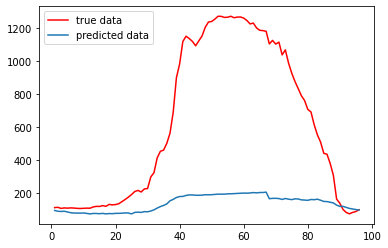

In [51]:
plot_validate_data(9)